<a href="https://colab.research.google.com/github/adampotton/MDM3-Rep-3/blob/main/inception_v3_aerial_trianing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive and imports

In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')
import os
import numpy as np

# Loading Numpy Data Arrays

In [ ]:
#if you get an error the first time just run it again
os.chdir('../../../')
!pwd
os.chdir('content')
os.chdir(r'drive/MyDrive/Aerial Data')
print(os.listdir())

train_labels = np.load('train_labels.npy')
train_images = np.load('train_images.npy')
test_labels = np.load('test_labels.npy')
test_images = np.load('test_images.npy')
val_labels = np.load('val_labels.npy')
val_images = np.load('val_images.npy')

# If Not using colab the following can be used to import the data

In [ ]:
import gdown

gdown.download(r'https://drive.google.com/file/d/1-7lEmQDmf06beJUD3NaQk82125NGqYpm/view?usp=drive_link', r'../../data/aerial_data/val_labels.npy',fuzzy=True)
gdown.download(r'https://drive.google.com/file/d/1-54Z1sN8uYgNG66MwWumRTlYMJmX7wWw/view?usp=drive_link', r'../../data/aerial_data/val_images.npy',fuzzy=True)
gdown.download(r'https://drive.google.com/file/d/1vKs-th9eHU_oMXTasVm-FD9Dximer82Q/view?usp=drive_link', r'../../data/aerial_data/train_labels.npy',fuzzy=True)
gdown.download(r'https://drive.google.com/file/d/1aJkI-7d5KCAAYCoXkrEcHVXvSsXc_-8n/view?usp=drive_link', r'../../data/aerial_data/train_images.npy',fuzzy=True)

# Loading numpy files from memory

In [2]:
import os
import numpy as np
#system specific
folder = '../../data/aerial_data'
train_images = np.load(os.path.join(folder, 'train_images.npy'))
train_labels = np.load(os.path.join(folder, 'train_labels.npy'))
val_images = np.load(os.path.join(folder, 'val_images.npy'))
val_labels = np.load(os.path.join(folder, 'val_labels.npy'))

In [ ]:
#inspecting data
print("train data:")
print("images shape:")
print(train_images.shape)
print("labels shape:")
print(train_labels.shape)

#print("test data:")
#print("images shape:")
#print(test_images.shape)
#print("labels shape:")
#print(test_labels.shape)

print("val data:")
print("images shape:")
print(val_images.shape)
print("labels shape:")
print(val_labels.shape)

print("image format check:")
print(train_images[0,:,:,0])

print("label check:")
print(train_labels[0])


# Performing Feature Extraction on Inception-V3, which is currently trained on image net
Adapted from: <https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb#scrollTo=NiFT4EYmprqG>

# Training Parameters

In [11]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Number of tree species categories
num_classes = 19

# Batch size for training (should be a power of 2 if training on the GPU and is limited by memory)
batch_size = 32

# Number of epochs to train for
num_epochs = 5

#True if we are just training the output layer of the network
feature_extract = True

print("cuda is available = ",torch.cuda.is_available())

C:\Users\bench\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda is available =  True


# Function For training the model

In [12]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=True, tensorboard_writer=None):
    
    if tensorboard_writer is not None:
        use_tensorboard = True
        writer = tensorboard_writer
    
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if use_tensorboard:
                            writer.add_scalar('Training Loss', loss, epoch)
                            writer.add_scalar('Training Accuracy', torch.sum(preds == labels.data).double() / len(labels), epoch)
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            #deep copying the model if its performance has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                if use_tensorboard:
                    writer.add_scalar('Validation Accuracy', epoch_acc, epoch)
                    writer.add_scalar('Validation Loss', epoch_loss, epoch)

        print("epoch {} complete".format(epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    if use_tensorboard:
        #making sure all data is written to disk
        writer.flush()
    
    # load best model weights and return best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Ensuring that model parameters are not used during training since we are only interested in the final layer

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Defining function to reshape the model to account for the number of classes
By default Inception-v3 has 1000 classes as it is trained on imageNet, whilst our dataset has 19

In [14]:
import torch
from collections import OrderedDict

def initialize_inception_model(num_classes, feature_extract, use_pretrained=True, model=None):
  # Initialize these variables which will be set in this if statement. Each of these
  #   variables is model specific.
  model_ft = None
  input_size = 0

  """ Inception v3
  Be careful, expects (299,299) sized images and has auxiliary output
  """
  if model is None:
    if use_pretrained:
      model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights='Inception_V3_Weights.IMAGENET1K_V1')
    else:
      model_ft = models.inception_v3('pytorch/vision:v0.10.0', 'inception_v3')
  else:
    model_ft = model
  #"switching off" training on the majority of the model weights if feature_extract
  set_parameter_requires_grad(model_ft, feature_extract)
  # Handle the auxilary net
  num_ftrs = model_ft.AuxLogits.fc.in_features
  model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
  # Handle the primary net
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, num_classes)
  input_size = 299
  #adding an initial 1x1 convolutional layer to handle 4 channel input and reduce it to 3 channels
  input_embedding_module = nn.Sequential(OrderedDict([('input_conv', nn.Conv2d(4, 3, kernel_size=1))]))#keeping this module seperate for future use
  #wrapping the pretrained modek and the input embedding module together for a combined model
  model_ft = nn.Sequential(OrderedDict([("pre_layer", input_embedding_module), ("inception_v3", model_ft)]))

  return model_ft, input_size


# Initializing Model


In [15]:
#initializing model
#Initialize the model for this run
model_ft, input_size = initialize_inception_model(num_classes, feature_extract, use_pretrained=True)
print(model_ft)

Using cache found in C:\Users\bench/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (pre_layer): Sequential(
    (input_conv): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (inception_v3): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm

# Formatting Loaded Data and creating data loader

In [16]:
from PIL import Image
#converting numpy arrays to PIL images
train_images_pil = [Image.fromarray(image) for image in train_images]
val_images_pil = [Image.fromarray(image) for image in val_images]
#creating one hot encoding labels from numpy arrays
train_categories, train_labels_numeric = np.unique(train_labels, return_inverse=True)
val_categories, val_labels_numeric = np.unique(val_labels, return_inverse=True)

print("Train Categories:", train_categories)
print("Train Labels Numeric:", train_labels_numeric[0:10])
print("Val Categories:", val_categories)
print("Val Labels Numeric:", val_labels_numeric[0:10])

Train Categories: ['Abies_alba' 'Acer_pseudoplatanus' 'Alnus_spec.' 'Betula_spec.'
 'Fagus_sylvatica' 'Fraxinus_excelsior' 'Larix_decidua' 'Larix_kaempferi'
 'Picea_abies' 'Pinus_nigra' 'Pinus_strobus' 'Pinus_sylvestris'
 'Populus_spec.' 'Prunus_spec.' 'Pseudotsuga_menziesii' 'Quercus_petraea'
 'Quercus_robur' 'Quercus_rubra' 'Tilia_spec.']
Train Labels Numeric: [ 4 12  8 17  4  4 14  3  8 11]
Val Categories: ['Abies_alba' 'Acer_pseudoplatanus' 'Alnus_spec.' 'Betula_spec.'
 'Fagus_sylvatica' 'Fraxinus_excelsior' 'Larix_decidua' 'Larix_kaempferi'
 'Picea_abies' 'Pinus_nigra' 'Pinus_strobus' 'Pinus_sylvestris'
 'Populus_spec.' 'Prunus_spec.' 'Pseudotsuga_menziesii' 'Quercus_petraea'
 'Quercus_robur' 'Quercus_rubra' 'Tilia_spec.']
Val Labels Numeric: [ 3  2  4 14  8  2  4  2  2  8]


In [38]:
print(train_images_pil[0])

<PIL.Image.Image image mode=RGBA size=304x304 at 0x1B39703E740>


In [17]:
if np.all(train_categories == val_categories):
    print("categories are consistent between train and val sets")
    categories = train_categories = val_categories
else:
    raise ValueError("Train and val categories don't match")

categories are consistent between train and val sets


In [18]:
# normalization for training and validation
# right now validation and training transform is the same and no augmentation
# Calculate mean and std for 4-channel images

#TODO: validate that this is correct (currently quite computationally expensive)
mean = np.mean(train_images, axis=(0, 1, 2)) / 255  # divide by 255 to normalize between 0 and 1
std = np.std(train_images, axis=(0, 1, 2)) / 255
print("Mean: ", mean)
print("Std: ", std)

# Update the normalization in the transform
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.Normalize(mean, std)])

#creating a custom pytorch dataset for the numpy arrays we loaded earlier
#with applied transforms
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)
          

        return image, label


#creating training and validation pytorch datasets
training_dataset = CustomDataset(train_images, train_labels_numeric, image_transform)
val_dataset = CustomDataset(val_images, val_labels_numeric, image_transform)

# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True),
                    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)}


Mean:  [0.58964574 0.35763393 0.32874096 0.30974565]
Std:  [0.1930043  0.13049523 0.11048656 0.12789797]


# Training the model

In [ ]:
## Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("sending model to",device)
# Send the model to GPU
model_ft = model_ft.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Creating the Optimizer
if feature_extract:
  params_to_update = []
  for name,param in model_ft.named_parameters():
    if param.requires_grad==True:
      params_to_update.append(param)
      print("\t",name)
else:
  params_to_update = model_ft.parameters()

print("number of parameters to train =",len(params_to_update))
for i, param in enumerate(params_to_update):
  print("parameter {}:".format(i),param.shape)


optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)







In [ ]:
#creating a tensorboard writer for logging
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/train_run_test")
# Train and evaluate
model_ft, hist = train_model(model_ft,
                             dataloaders_dict,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs,
                             is_inception=True,
                             tensorboard_writer=writer)

torch.save(model_ft.state_dict(),'temp.pth')

# Visualizing the dataset and model layers with tensorboard

----unnormalized images from training data----


<Figure size 640x480 with 0 Axes>

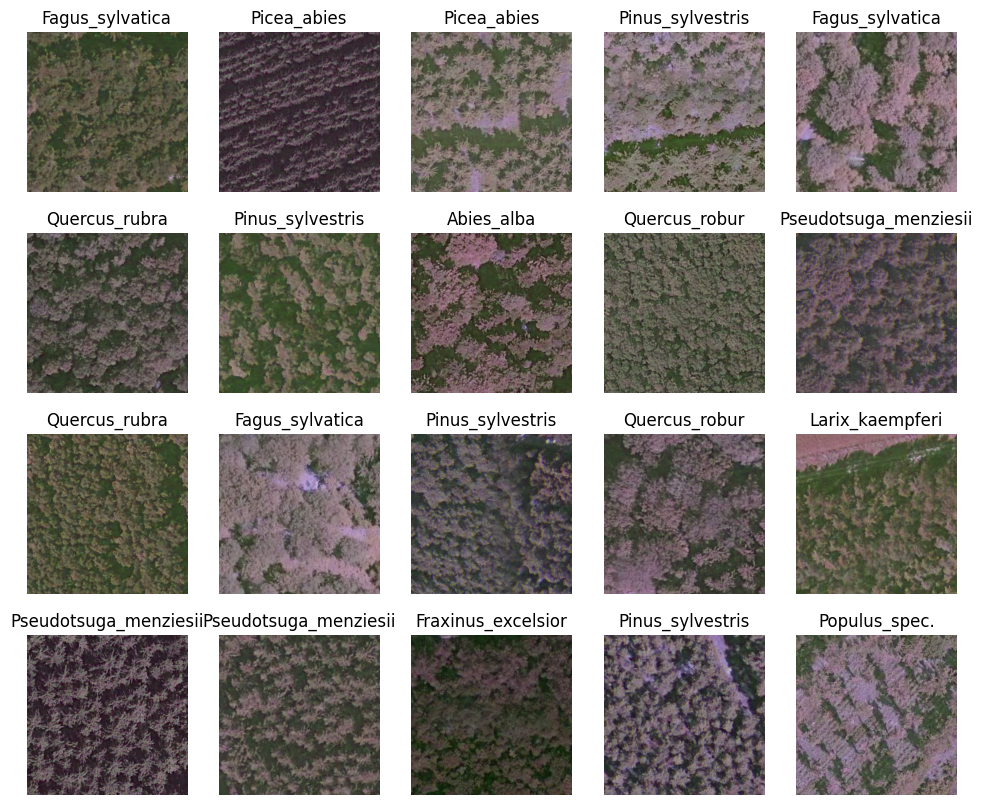

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

----normalized images from training data----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

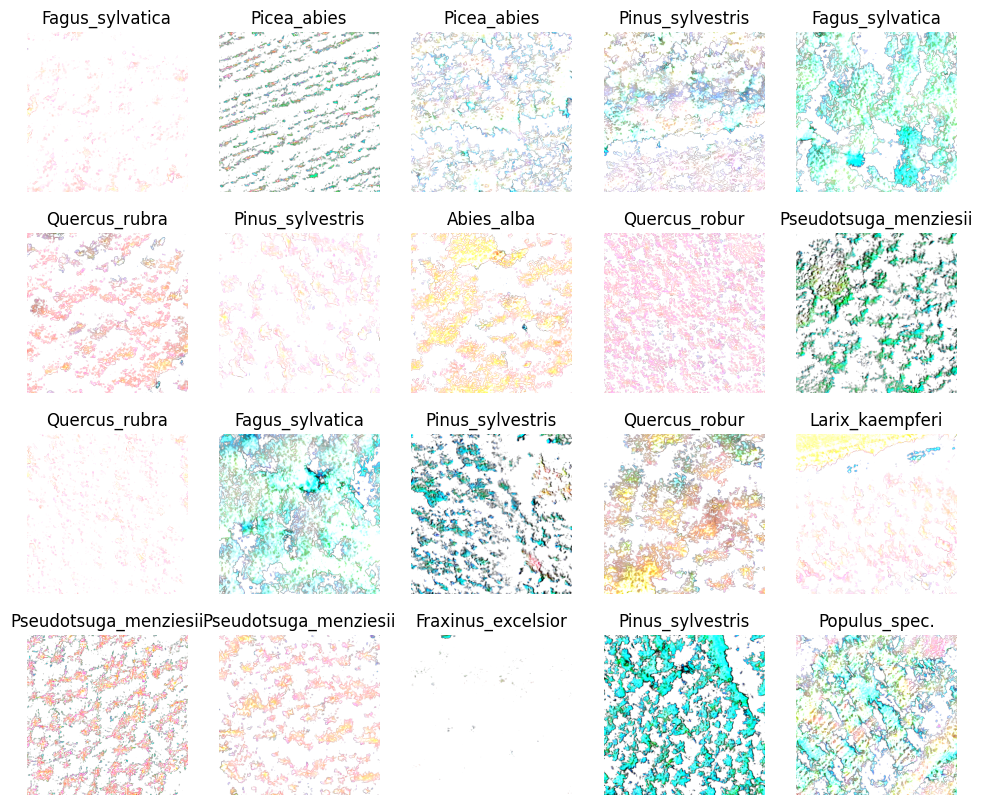

----denormalized images from training data----


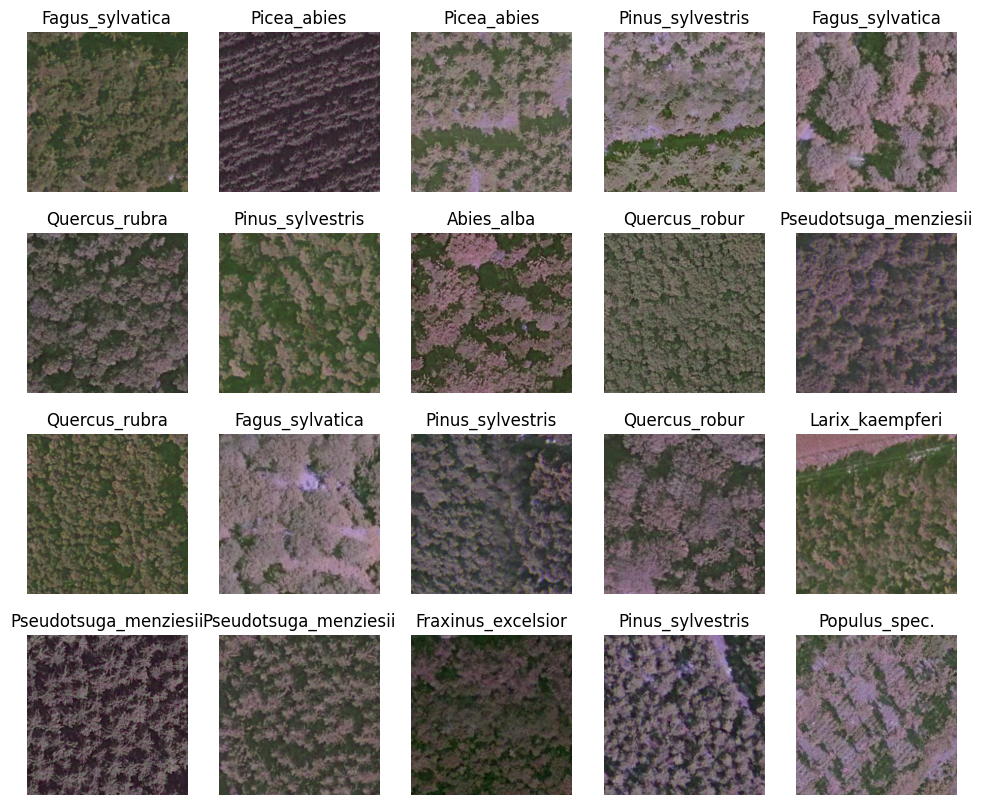

In [32]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

#visuallizing training data
# Select 20 random indices
random_indices = random.sample(range(train_images.shape[0]), 20)
plt.tight_layout()

print("----unnormalized images from training data----")
# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in zip(random_indices, axes.flatten()):
    ax.imshow(train_images[i,:,:,1:])
    ax.set_title(train_labels[i])  # Add title to each image
    ax.axis('off')

plt.show()
print("----normalized images from training data----")
# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in zip(random_indices, axes.flatten()):
    
    ax.imshow(training_dataset[i][0].permute(1, 2, 0))
    ax.set_title(train_labels[i])  # Add title to each image
    ax.axis('off')

plt.show()
print("----denormalized images from training data----")
unorm = transforms.Normalize(-np.divide(mean,std), 1/std)

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in zip(random_indices, axes.flatten()):
    image = unorm(training_dataset[i][0])
    
    ax.imshow(image[1:,:,:].permute(1, 2, 0))
    ax.set_title(train_labels[i])  # Add title to each image
    ax.axis('off')

plt.show()


# print("train_images shape:",train_images.shape)
# for i in range(10):
#     writer.add_images('unnormalized_images, batch {}'.format(i),
#                         train_images[(i*20):(i*20+20),:,:,1:],
#                         i,
#                         dataformats='NHWC')

# for i in range(10):
#     writer.add_images('first_layer_embedding_normalized_3',
#                         training_dataset[i][0][:3,:,:], 
#                         i,
#                         dataformats='CHW'
#     )

# for i in range(10):
#     image_4c = training_dataset[i][0]
#     image_3c = model_ft.pre_layer.input_conv(image_4c)
#     writer.add_images('first_layer_embedding',
#                         image_3c, 
#                         i,
#                         dataformats='CHW'
#     )




In [ ]:
%reload_ext tensorboard

# Testing Trained Model

### Downloading test data

In [ ]:
import gdown

gdown.download(r'https://drive.google.com/file/d/1-4ZKGtGrWCEfaRDBobEgeQJmtdJIFobi/view?usp=drive_link', r'../../data/aerial_data/test_labels.npy',fuzzy=True)
gdown.download(r'https://drive.google.com/file/d/1-01C3LjzGSz7QGzvharc52yZRwEgMzni/view?usp=drive_link', r'../../data/aerial_data/test_images.npy',fuzzy=True)

### Loading Test Data

In [ ]:
import numpy as np
from PIL import Image
import os
print(os.getcwd())
test_labels = np.load('../../data/aerial_data/test_labels.npy')
test_images = np.load('../../data/aerial_data/test_images.npy')

#converting numpy arrays into RGB PIL images, ignoring the IR channel for now
test_images_pil = [Image.fromarray(image) for image in test_images]
#creating one hot encoding labels from numpy arrays
test_categories, test_categories_numeric = np.unique(test_labels, return_inverse=True)

print("Test Categories:", test_categories)
print("train Categories:", train_categories)

test_dataset = CustomDataset(test_images_pil, test_categories_numeric, image_transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### evaluating on test data

In [ ]:
import torch
import torch.nn.functional as F

model_file = 'training_run_2_4_channels.pth'
trained_model, _ = initialize_inception_model(num_classes, feature_extract, use_pretrained=True)
trained_model.load_state_dict(torch.load(model_file))
trained_model.to(device)
trained_model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = trained_model(images)
        #applying softmax to model logits. This is done implicitley during the training but not during evaluation
        outputs = F.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

accuracy = correct_predictions / total_predictions
print("Number of test predictions:", total_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2%}")


In [ ]:
print(trained_model)